## TODO
class vehicle movement predictor
put vehicle to x0,y0,a0 and rotate all the points
receive vehicle north and host point


In [1]:
print('test')

test


## Cameras

In [2]:
from src.vision import Camera

mba_video_camera = Camera(
    h_fov=59.0,
    h_res=1080,
    v_res=720,
)

mba_photo_camera = Camera(
    h_fov=67.0,
    h_res=1290,
    v_res=720,
)

zed_two_camera = Camera(
    h_fov=110.0,
    v_fov=70.0,
)

avg_shoulder_width = 350.0
avg_torso_height = 460.0


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import pandas as pd
import cv2
import time

import torch

from src.vehicle import Vehicle
from src.point import Point
from src.vision import FakeSensor
from src.point import create_map

from scipy.interpolate import LSQUnivariateSpline



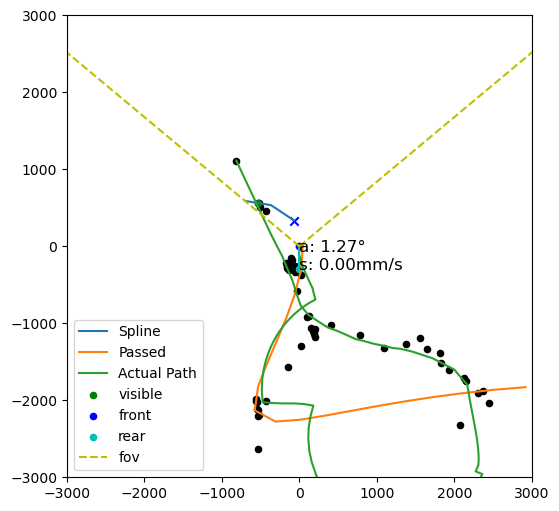

In [9]:
# VEHICLE
vehicle = Vehicle(
    max_turn_angle=30, 
    axle_len=300, 
    max_speed=2000, 
    camera=zed_two_camera,
    center=Point(0, 0)
)

actual_path = pd.DataFrame(columns=['x', 'y'])
actual_path = pd.concat([actual_path, pd.DataFrame({
    'x': 0, # x position
    'y': 0, # y position
}, index=[len(actual_path)])])


# FAKE SENSOR
sensor_data = pd.read_csv('dist_2fps.csv', header=None)
sensor_data.columns = ['t', 'x', 'y']
sensor_data['t'] = sensor_data['t'].astype(float)
fake_sensor = FakeSensor(sensor_data, to_recenter=True)


# ALGORITHM DATA
seen = pd.DataFrame(columns=['t', 'x', 'y'])
seen = pd.concat([seen, pd.DataFrame({
    't': 0, # timestamp
    'x': 0, # x position
    'y': 0, # y position
}, index=[len(seen)])])



def capture(fake_sensor, vehicle, seen):
    new_seen = fake_sensor.capture(vehicle)
    has_seen = new_seen is not None
    if has_seen:
        seen = pd.concat([seen, pd.DataFrame({
            't': [fake_sensor.time()],
            'x': [new_seen.x],
            'y': [new_seen.y]
        }, index=[len(seen)])])
    last_seen = Point.from_df(seen.iloc[-1])
    return seen, last_seen, has_seen


def recenter(vehicle, seen, actual_path):
    front = vehicle.get_front()
    seen = front.rotate_df(front.a, seen, recenter=True)

    actual_path = front.rotate_df(front.a, actual_path, recenter=True)
    actual_path = pd.concat([actual_path, pd.DataFrame({
        'x': 0, # x position
        'y': 0, # y position
    }, index=[len(actual_path)])])

    last_seen = Point.from_df(seen.iloc[-1])
    fake_sensor.recenter(vehicle)

    vehicle.recenter()
    return seen, last_seen, actual_path


def get_last_seen(seen, count):
    count = min(count, len(seen))
    return seen.iloc[-count:]


def get_spline(df_points):

    if len(last_points) < 6:
        return [Point.from_df(df_points.iloc[-1])]
    
    ti = np.array(last_points.index, dtype=float)
    num_knots = max(1, len(last_points) // 8)
    t_knots = np.linspace(ti.min(), ti.max(), num_knots)[1:-1]
    spline_x = LSQUnivariateSpline(ti, last_points['x'], t_knots)
    spline_y = LSQUnivariateSpline(ti, last_points['y'], t_knots)

    min_distance = 300
    sampled_points = []
    last_point = None
    
    # Iterate over the spline
    for ti in np.linspace(ti.min(), ti.max(), 100):
        current_point = Point(spline_x(ti), spline_y(ti), 0)

        if last_point is None:
            # First point
            sampled_points.append(current_point)
            last_point = current_point
        else:
            # Check distance
            if current_point.distance(last_point) >= min_distance:
                sampled_points.append(current_point)
                last_point = current_point

    return sampled_points


def get_spline_df(points):
    spline = get_spline(points)
    return pd.DataFrame({
        'x': [p.x for p in spline],
        'y': [p.y for p in spline],
    })


def get_target(df_spline_incoming, last_seen):
    if len(df_spline_incoming) == 0:
        return last_seen
    else:
        return Point.from_df(df_spline_incoming.iloc[0])


def get_incoming(df_points, min_distance=300):
    return df_points[df_points['x'] > min_distance], df_points[df_points['x'] <= min_distance]


smoothing = 4
time_smoothing = 1 / smoothing
while not (vehicle.has_stopped() and fake_sensor.is_done()):
    seen, last_seen, has_seen = capture(fake_sensor, vehicle, seen)

    for _ in range(smoothing):
        last_points = get_last_seen(seen, 25)
        incoming, passed = get_incoming(get_spline_df(last_points))
        target = get_target(incoming, last_seen)

        vehicle.follow_target(target, last_seen, time_smoothing, has_seen)
        seen, last_seen, actual_path = recenter(vehicle, seen, actual_path)

        fig, ax = create_map(Point(0, 0), 6000, 6)
        ax.scatter(target.y, target.x, marker='x', color='b')
        ax.plot(incoming['y'], incoming['x'], label='Spline')
        ax.plot(passed['y'], passed['x'], label='Passed')
        Point(0, 0).scatter(ax, color='r', size=20)
        for x in range(len(seen)):
            Point.from_df(seen.iloc[x]).scatter(ax, color='k', size=20)
    
        ax.plot(actual_path['y'], actual_path['x'], label='Actual Path')

        fake_sensor.scatter_host(ax, vehicle)
        vehicle.plot(ax)
        ax.legend()
        plt.show()

